<a href="https://colab.research.google.com/github/jdvf/CodeAcademy-Build-Web-APIs/blob/master/Desafio2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#importar librerias y csv

In [0]:
!pip install PyDrive;

     |████████████████████████████████| 993kB 4.9MB/s 
  Stored in directory: /root/.cache/pip/wheels/fa/d2/9a/d3b6b506c2da98289e5d417215ce34b696db856643bad779f4
Successfully built PyDrive


In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

downloaded = drive.CreateFile({'id':"0BzVrTKc02N8qNUdDSExBQlFTNlU"})   # replace the id with id of file you want to access
downloaded.GetContentFile('properatti.csv')        # replace the file name with your file

In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import ast, json

import plotly
import plotly.plotly as py
import plotly.tools as tls
import plotly.graph_objs as go
from plotly.graph_objs import *
from plotly.offline import init_notebook_mode, iplot, plot


import matplotlib.pyplot as plt
% matplotlib inline
plt.style.use('bmh')

usuario = 'jdvf86'
key_api = 'YC7oObUABV0NNwHU0Lsy'
plotly.tools.set_credentials_file(username = usuario, api_key = key_api)


pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 20)
pd.set_option('display.width', 200)
pd.set_option('display.max_colwidth', 901)  # or 199

#Preparar los datos



1.   Importar el CSV



In [131]:
#Crear un objeto pandas con el CSV
df = pd.read_csv('properatti.csv');


"""   
for c in df.columns:
    print('-----{}-----'.format(c))
    print(df[c].value_counts())
    print('total = {}'.format(df[c].value_counts().sum()))
    print('')

""" 


"   \nfor c in df.columns:\n    print('-----{}-----'.format(c))\n    print(df[c].value_counts())\n    print('total = {}'.format(df[c].value_counts().sum()))\n    print('')\n\n"

-----localidad-----
Belgrano                2992
Palermo                 2885
Caballito               2273
Villa Urquiza           1629

-----tipo_propiedad-----
apartment    2761
house         121
store          67
PH             43

-----moneda-----
USD    2394
ARS     140


Restringuimos el DS a 

*   Belgrano (la Localidad de CABA con mas propiedades publicadas despues de los Palermos).
*   Moneda USD
*   Tipo de propiedad Departamento





In [0]:
df = df[ df['state_name'].isin(['Capital Federal'])]
df = df[ df['place_name'].isin(['San Telmo'])]
df = df[ df['currency'].isin(['USD'])]
df = df[ df['property_type'].isin(['apartment'])]

Eliminamos y renombramos columnas

In [133]:

#Remover las columnas que no aportan informacion
df = df.drop(['Unnamed: 0',
       'operation',
       'property_type',
       'place_name',
       'place_with_parent_names',
       'country_name',
       'state_name',
       'geonames_id',
       'lat-lon',
       #'lat',
       #'lon',
       #'price',
       'currency',
       'price_aprox_local_currency',
       'price_aprox_usd',
       #'surface_total_in_m2',
       #'surface_covered_in_m2',
       'price_usd_per_m2',
       'price_per_m2',
        'floor',
       #'rooms',
       'expenses',
       'properati_url',
      # 'description',
      # 'title',
       'image_thumbnail' ], axis=1)


#Renombramos columnas
df.rename(columns={
'place_name': 'localidad',
'price': 'precio',
'surface_total_in_m2': 'm2_totales',
'surface_covered_in_m2': 'm2_cubiertos',
'rooms': 'ambientes',
'description': 'descripcion',
'title': 'titulo'}, inplace=True)

df.isna().sum()

lat             196
lon             196
precio            0
m2_totales      130
m2_cubiertos     17
ambientes       399
descripcion       0
titulo            0
dtype: int64

Completar nulos en superficie

In [134]:
#completamos metros cuadrados totales con m2 cubiertos
df.m2_totales = np.where(df.m2_totales.isnull(), df.m2_cubiertos, df.m2_totales)

#eliminamos las filas con valores nulos en metros2 totales
df.dropna(subset=['m2_totales'], inplace=True)

#completamos metros cuadrados cubiertos con m2 totales
df.m2_cubiertos = np.where(df.m2_cubiertos.isnull(), df.m2_totales, df.m2_cubiertos)

print(df.isna().sum())

lat             195
lon             195
precio            0
m2_totales        0
m2_cubiertos      0
ambientes       396
descripcion       0
titulo            0
dtype: int64


Imputacion de ambientes y piso mediante regex

In [0]:
import re

def is_number(str_value):
    try: 
        int(str_value)
        return True
    except ValueError:
        return False
#END is_number


def extract_from_text(dataframe, col_name, pattern, new_col_name):
    numeros = {"un": 1,"mono": 1, "uno": 1, "dos": 2, "tres": 3, "cuatro": 4, "cinco": 5, "seis": 6, "siete": 7, "ocho": 8, "nueve": 9, "primer": 1, "primero": 1, "segundo": 2, "tercer": 3, "tercero" : 3, "cuarto": 4, "quinto": 5, 
               "sexto": 6, "septimo": 7, "séptimo": 7, "octavo": 8, "noveno": 9, "decimo": 10, "décimo": 10}
    regex = re.compile(pattern, flags = re.IGNORECASE)
    new_col = []

    for desc in dataframe[col_name]:
        try:
            match = regex.search(desc)
            if match: #insertar primer grupo de captura
                if is_number(match[1]) : # ver si string es numero
                    new_col.append(int(match[1]))
                else: # si numero escrito como palabra, usar diccionario
                    valor = numeros[match[1].lower()]
                    new_col.append(valor)
            else: 
                new_col.append(np.nan)
        except TypeError:
            new_col.append(np.nan)
    dataframe[new_col_name] = new_col
 #END extract_from_file

In [0]:
extract_from_text(df,
                         "descripcion",
                         r"\b(\d)\s*ambi?e?n?t?e?|\b(uno?|dos|tres|cuatro|cinco|seis|siete|ocho|nueve)\b\s*ambi?e?n?t?e?", 
                         "ambientes2")

extract_from_text(df, 
                         "descripcion",
                         r"\b(\d)\s*dormi?t?o?r?i?o|\b(uno?|dos|tres|cuatro|cinco|seis|siete|ocho|nueve)\b\s*dormi?t?o?r?i?o?", 
                         "dormitorios")

In [0]:
# agregar 1 a dormitorios para tomar en cuenta el living como un ambiente más
df["dormitorios"] = df["dormitorios"] +1


In [0]:
# llenar los nulos en rooms con ambientes 
df['ambientes'] = df['ambientes'].fillna(df['ambientes2'])
# llenar los nulos que quedan en rooms con dormitorios
df["ambientes"] = df['ambientes'].fillna(df['dormitorios'])


In [0]:
# borrar las columnas creadas por extract_from_description
df.drop(['ambientes2', 'dormitorios'], axis='columns', inplace=True)

In [140]:

print(df.isna().sum())

lat             195
lon             195
precio            0
m2_totales        0
m2_cubiertos      0
ambientes       121
descripcion       0
titulo            0
dtype: int64


Agregar features

In [0]:
#Antes removemos titulo y descripion
df = df.drop(['descripcion', 'titulo'], axis=1)

In [142]:
#Agregamos Precio por M2 Cubierto y Precio por M2 Total
df['precio_m2_c'] = df['precio'] / df['m2_cubiertos']
df['precio_m2_t'] = df['precio'] / df['m2_totales']

df.describe()


,lat,lon,precio,m2_totales,m2_cubiertos,ambientes,precio_m2_c,precio_m2_t
count,533.000000,533.000000,7.280000e+02,728.000000,728.000000,607.000000,728.000000,728.000000
mean,-34.620219,-58.376326,1.989301e+05,335.862637,329.482143,2.219110,inf,2340.768905
std,0.006288,0.006196,1.723848e+06,7410.397350,7410.590876,1.441865,NaN,586.956127
min,-34.649557,-58.423096,2.240000e+04,13.000000,0.000000,1.000000,232.727225,232.727225
25%,-34.624430,-58.377485,8.689800e+04,39.000000,35.000000,1.000000,2168.995098,2009.825080
50%,-34.620953,-58.375554,1.214790e+05,51.000000,46.000000,2.000000,2621.455939,2391.958333
75%,-34.617231,-58.373245,1.476190e+05,58.000000,49.250000,3.000000,2984.020408,2665.500000
max,-34.573789,-58.365624,4.654544e+07,200000.000000,200000.000000,14.000000,inf,5989.583333


Split Train y Test

In [0]:
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

Identificar y remover outliers en Train

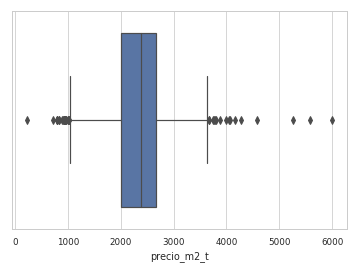

In [144]:
MAX_ROWS = 10
pd.set_option('display.max_rows', MAX_ROWS)
pd.set_option('display.max_columns', 200)
sns.set_style("whitegrid")
sns.set_context("paper")


sns.boxplot(x=df['precio_m2_t'])

In [145]:
df.columns

Index(['lat', 'lon', 'precio', 'm2_totales', 'm2_cubiertos', 'ambientes', 'precio_m2_c', 'precio_m2_t'], dtype='object')

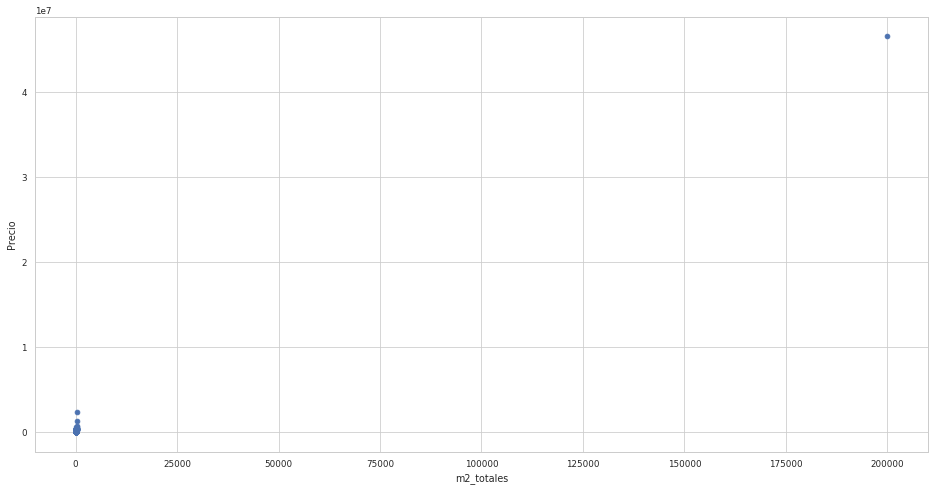

In [146]:
#Multivariate outlier analysis
fig, ax = plt.subplots(figsize=(16,8))
ax.scatter(df['m2_totales'], df['precio'])
ax.set_xlabel('m2_totales')
ax.set_ylabel('Precio')
plt.show()

eliminando outliers con tecnica ConvexHull 

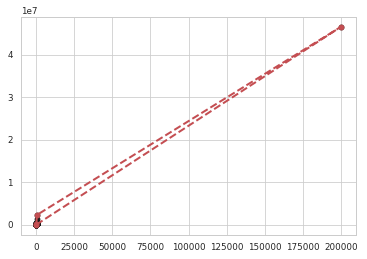

In [147]:
# en Precio xm2 total
# Load in convex hull method
from scipy.spatial import ConvexHull

# Define the set of our points
points = df[["m2_totales", "precio"]].values

# Calculate the position of the points in the convex hull
hull = ConvexHull(points)

# Plot the convex hull over the scatter plot
plt.plot(df["m2_totales"], df["precio"], 'ok')
plt.plot(points[hull.vertices, 0], points[hull.vertices,1], 'r--', lw = 2)
plt.plot(points[hull.vertices, 0], points[hull.vertices,1], 'ro', lw = 2)

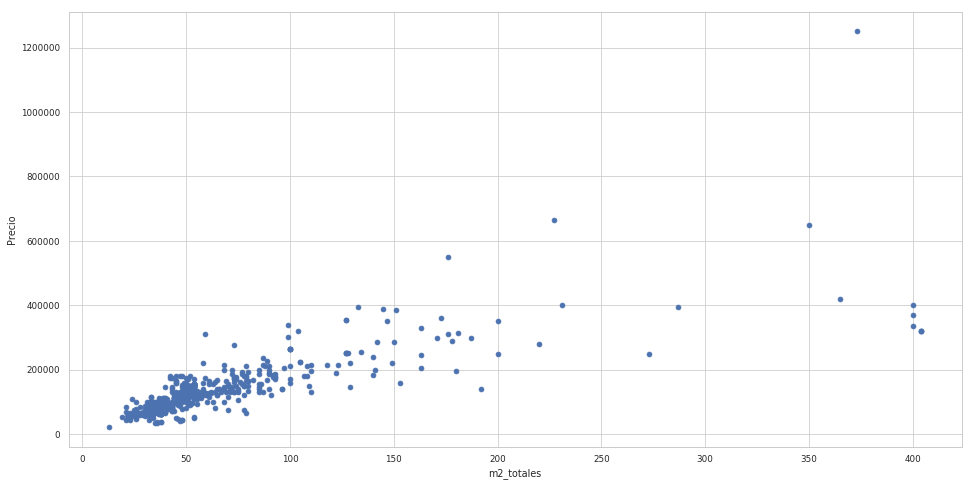

In [148]:
df=df.reset_index(drop=True).loc[~df.reset_index(drop=True).index.isin(hull.vertices)]

#Multivariate outlier analysis
fig, ax = plt.subplots(figsize=(16,8))
ax.scatter(df['m2_totales'], df['precio'])
ax.set_xlabel('m2_totales')
ax.set_ylabel('Precio')
plt.show()

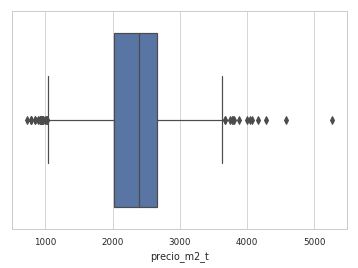

In [149]:
sns.boxplot(x=df['precio_m2_t'])

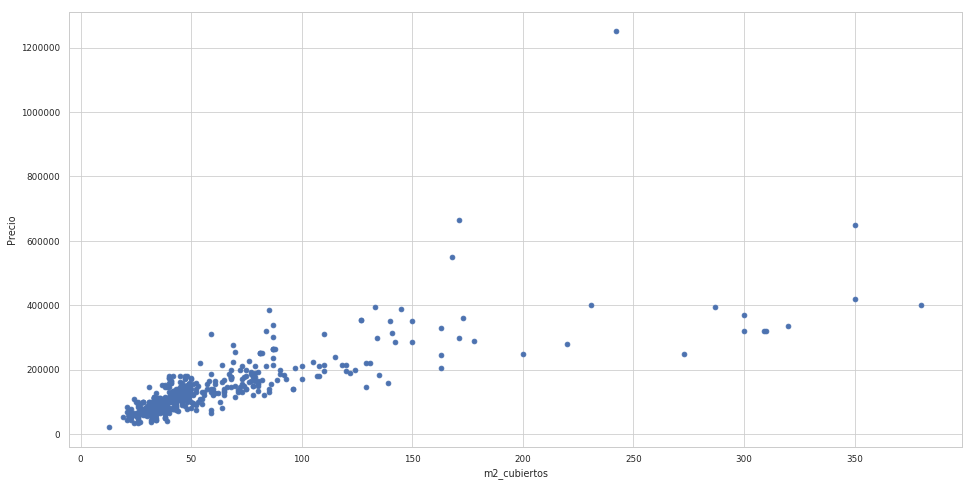

In [150]:
#eliminando outliers con tecnica ConvexHull en Precio xm2 Cubierto

fig, ax = plt.subplots(figsize=(16,8))
ax.scatter(df['m2_cubiertos'], df['precio'])
ax.set_xlabel('m2_cubiertos')
ax.set_ylabel('Precio')
plt.show()

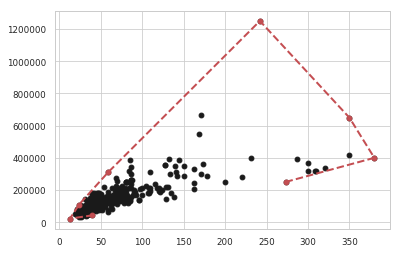

In [151]:
# en Precio xm2 total
# Load in convex hull method
from scipy.spatial import ConvexHull

# Define the set of our points
points = df[["m2_cubiertos", "precio"]].values

# Calculate the position of the points in the convex hull
hull = ConvexHull(points)

# Plot the convex hull over the scatter plot
plt.plot(df["m2_cubiertos"], df["precio"], 'ok')
plt.plot(points[hull.vertices, 0], points[hull.vertices,1], 'r--', lw = 2)
plt.plot(points[hull.vertices, 0], points[hull.vertices,1], 'ro', lw = 2)

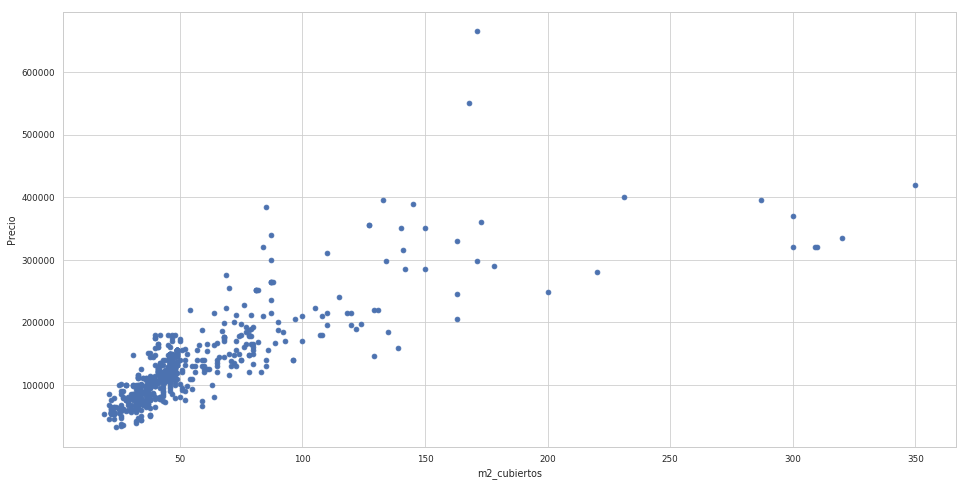

In [152]:
df=df.reset_index(drop=True).loc[~df.reset_index(drop=True).index.isin(hull.vertices)]

fig, ax = plt.subplots(figsize=(16,8))
ax.scatter(df['m2_cubiertos'], df['precio'])
ax.set_xlabel('m2_cubiertos')
ax.set_ylabel('Precio')
plt.show()

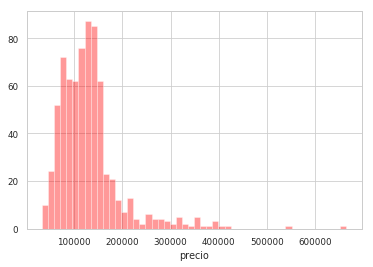

In [153]:
#Index(['lat', 'lon', 'precio', 'm2_totales', 'm2_cubiertos', 'ambientes', 'precio_m2_c', 'precio_m2_t'], dtype='object')

sns.distplot(df['precio'], kde=False, color='red', bins=50)


**Agregando otras columnas**

Correlaciones

In [154]:
df.describe()

,lat,lon,precio,m2_totales,m2_cubiertos,ambientes,precio_m2_c,precio_m2_t
count,521.000000,521.000000,716.000000,716.000000,716.000000,596.000000,716.000000,716.000000
mean,-34.620365,-58.376309,129510.899441,59.410615,53.163408,2.179530,2582.570758,2333.756826
std,0.006053,0.006240,65504.744303,44.445854,37.541360,1.342136,596.357333,529.766710
min,-34.649557,-58.423096,32772.000000,19.000000,19.000000,1.000000,1032.258065,729.166667
25%,-34.624430,-58.377442,86898.000000,39.000000,35.000000,1.000000,2179.480769,2023.404908
50%,-34.621007,-58.375515,121100.000000,51.000000,46.000000,2.000000,2621.455939,2393.094697
75%,-34.617281,-58.373245,147344.000000,57.000000,49.000000,3.000000,2961.858863,2664.294118
max,-34.573789,-58.365624,665000.000000,404.000000,350.000000,14.000000,4750.709677,4285.714286


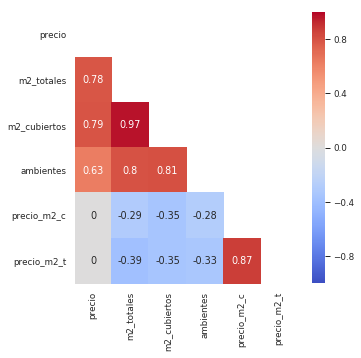

In [155]:
#Buscando correlaciones
#Index(['lat', 'lon', 'precio', 'm2_totales', 'm2_cubiertos', 'ambientes', 'precio_m2_c', 'precio_m2_t'], dtype='object')

subjective_corr = df[['precio', 'm2_totales', 'm2_cubiertos', 'ambientes', 'precio_m2_c', 'precio_m2_t']].corr()
subjective_corr[np.abs(subjective_corr)<.2] = 0
mask = np.zeros_like(subjective_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(5,5))
sns.heatmap(subjective_corr,
            vmin=-1,
            cmap='coolwarm',
            annot=True,
            mask = mask
           );

# ZIP Code


In [156]:
!pip install uszipcode

In [157]:
df.sample()

,lat,lon,precio,m2_totales,m2_cubiertos,ambientes,precio_m2_c,precio_m2_t
494,NaN,NaN,135879.0,51.0,46.0,NaN,2953.891304,2664.294118


In [158]:
#https://towardsdatascience.com/mapping-inequality-in-peer-2-peer-lending-using-geopandas-part-1-b8c7f883d1ba44


from uszipcode import Zipcode
from uszipcode import SearchEngine
search = SearchEngine(simple_zipcode=True) # set simple_zipcode=False to use rich info database


# Search zipcode within 30 miles, ordered from closest to farthest
result = search.by_coordinates(-34.561999, -58.444496, radius=10, returns=5)
result

zipcode = search.by_zipcode("1425")
zipcode


SimpleZipcode(zipcode=None, zipcode_type=None, major_city=None, post_office_city=None, common_city_list=None, county=None, state=None, lat=None, lng=None, timezone=None, radius_in_miles=None, area_code_list=None, population=None, population_density=None, land_area_in_sqmi=None, water_area_in_sqmi=None, housing_units=None, occupied_housing_units=None, median_home_value=None, median_household_income=None, bounds_west=None, bounds_east=None, bounds_north=None, bounds_south=None)